# The study of handwritten digits character recognition, also known as optical character recognition (OCR), is important for several reasons including document digitization, formprocessing, banking and finance, handwritten-based user authentication and so on. The taskhere is to correctly classify the handwritten digits in the MNIST dataset using ConvolutionalNeural Network (CNN). The dataset can be found at: http://yann.lecun.com/exdb/mnist/ Based on this task, we would consider the following questions:                                     a) How did the use of different regularisation methods affect the performance our CNN model?                                                                                                         b) Report how changes to the number of convolution blocks affect the performance of the model quantitatively?                                                                c) What is the effect of varying learning rates on the performance of the CNN algorithm.                                                                                                                     d) Was there a case of overfitting observed in your model at any point ?  

Step 1: import necessary libraries

In [ ]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm
import gzip
import numpy as np

print(tf.__version__)

2.12.0


Step 2: Load the dataset (image files)

In [ ]:
filename = '/content/t10k-labels-idx1-ubyte.gz'
test_labels = []

# Open the gzip file
with gzip.open(filename, 'rb') as f:
    # Read the first byte to get the magic number
    magic = int.from_bytes(f.read(4), byteorder='big')

    # Read the number of labels
    num_labels = int.from_bytes(f.read(4), byteorder='big')

    # Read the labels and append them to test_labels
    test_labels.extend([int.from_bytes(f.read(1), byteorder='big') for _ in range(num_labels)])

# Convert the dtype of test_labels to np.array
test_labels = np.array(test_labels, dtype=np.uint64)


In [ ]:
filename = '/content/train-labels-idx1-ubyte.gz'
train_labels = []

# Open the gzip file
with gzip.open(filename, 'rb') as f:
    # Read the first byte to get the magic number
    magic = int.from_bytes(f.read(4), byteorder='big')

    # Read the number of labels
    num_labels = int.from_bytes(f.read(4), byteorder='big')

    # Read the labels and append them to test_labels
    train_labels.extend([int.from_bytes(f.read(1), byteorder='big') for _ in range(num_labels)])

# Convert the dtype of test_labels to np.array
train_labels = np.array(train_labels, dtype=np.uint64)


In [ ]:
import struct

with gzip.open('/content/t10k-images-idx3-ubyte.gz', 'rb') as f:
    # Read the header information
    magic_number = struct.unpack('>I', f.read(4))[0]
    num_images = struct.unpack('>I', f.read(4))[0]
    num_rows = struct.unpack('>I', f.read(4))[0]
    num_cols = struct.unpack('>I', f.read(4))[0]

    # Read the image data
    images_raw = f.read()

# Parse the image data into a list of images
image_size = num_rows * num_cols
test_images = []
for i in range(num_images):
    image_start = i * image_size
    image_end = image_start + image_size
    image_raw = images_raw[image_start:image_end]
    image = list(image_raw)
    test_images.append(image)
    # test_images = np.array(test_images, dtype=np.uint8)


In [ ]:
with gzip.open('/content/train-images-idx3-ubyte.gz', 'rb') as f:
    # Read the header information
    magic_number = struct.unpack('>I', f.read(4))[0]
    num_images = struct.unpack('>I', f.read(4))[0]
    num_rows = struct.unpack('>I', f.read(4))[0]
    num_cols = struct.unpack('>I', f.read(4))[0]

    # Read the image data
    images_raw = f.read()

# Parse the image data into a list of images
image_size = num_rows * num_cols
train_images = []
for i in range(num_images):
    image_start = i * image_size
    image_end = image_start + image_size
    image_raw = images_raw[image_start:image_end]
    image = list(image_raw)
    train_images.append(image)


In [ ]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four',
               'Five', 'Six', 'Seven', 'Eight', '(Nine)']

train_images = np.array(train_images)
test_images = np.array(test_images)
# train_labels = np.array(train_labels, dtype=np.unit8)
# test_labels = np.array(test_labels, dtype=np.unit8)

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 784), of int64
Test_images.shape: (10000, 784), of int64


## Reshaping Image Data for Modeling

We do need to reshape our data before we train our model. Here we will work on grayscale, 1-channel images (image pixel tensors)

Step 3. Preprocess the data

In [ ]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)
class_names = ['ZERO', 'ONE', 'TWO', 'THREE', 'FOUR', 'FIVE',
               'SIX', 'SEVEN', 'EIGHT', 'NINE']
print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of int64
Test_images.shape: (10000, 28, 28, 1), of int64


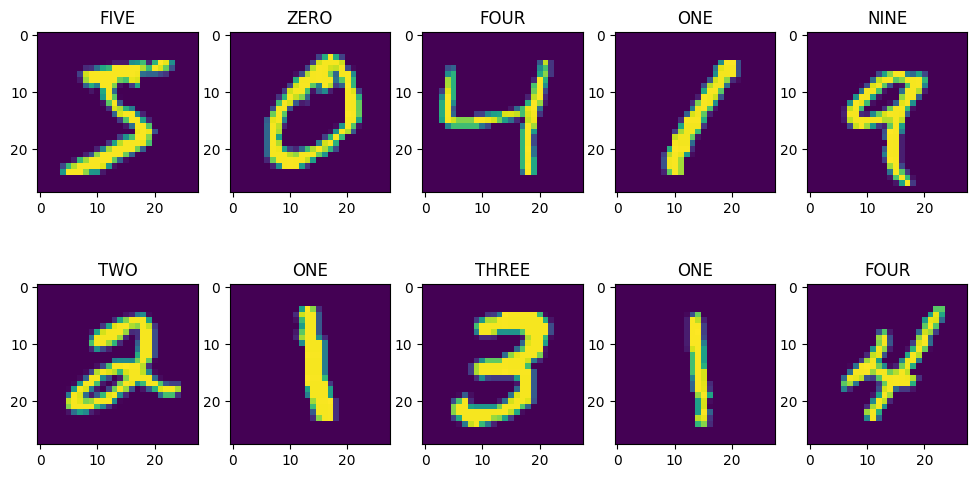

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
c = 0
for i in range(10):
    idx = i // 5
    idy = i % 5
    ax[idx, idy].imshow(train_images_gr[i].reshape(28,28))
    ax[idx, idy].set_title(class_names[train_labels[i]])

Step 4. Build the model (constructor stage)

In [ ]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
L1_regularizer_model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
L1_regularizer_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer='L1',
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
L1_regularizer_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
L1_regularizer_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer='L1',
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
L1_regularizer_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
L1_regularizer_model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
L1_regularizer_model.add(tf.keras.layers.Dense(256, activation='relu'))
L1_regularizer_model.add(tf.keras.layers.Dropout(rate=0.3))
L1_regularizer_model.add(tf.keras.layers.Dense(256, activation='relu'))
L1_regularizer_model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
L1_regularizer_model.add(tf.keras.layers.Dense(10, activation='softmax'))


Step 5: Compile the model (Compilation stage)

In [ ]:
# compile model
L1_regularizer_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# view model layers
L1_regularizer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

## Model Training

Let’s train our model for 100 epochs and look at the performance. We do apply an early-stopping to stop the model training immediately once we don't see an improvement in validation-loss over the last 2 epochs using the `EarlyStopping` callback.

Step 6: Train the model (Training stage)

In [ ]:
EPOCHS = 100
train_images_scaled = train_images_gr / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
                                               restore_best_weights=True,
                                               verbose=1)

L1_regularizer_model_history = L1_regularizer_model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback],
                    validation_split=0.2, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1500/1500 [==============================] - 18s 5ms/step - loss: 0.5183 - accuracy: 0.9185 - val_loss: 0.2036 - val_accuracy: 0.9683
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2001 - accuracy: 0.9632 - val_loss: 0.1556 - val_accuracy: 0.9742
Epoch 3/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1653 - accuracy: 0.9708 - val_loss: 0.1395 - val_accuracy: 0.9776
Epoch 4/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1502 - accuracy: 0.9736 - val_loss: 0.1350 - val_accuracy: 0.9770
Epoch 5/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1382 - accuracy: 0.9754 - val_loss: 0.1253 - val_accuracy: 0.9816
Epoch 6/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1288 - accuracy: 0.9780 - val_loss: 0.1156 - val_accuracy: 0.9828
Epoch 7/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1192 - accuracy: 0.9796 - val_loss: 0.1220 - val_a

## Plot Learning Curves

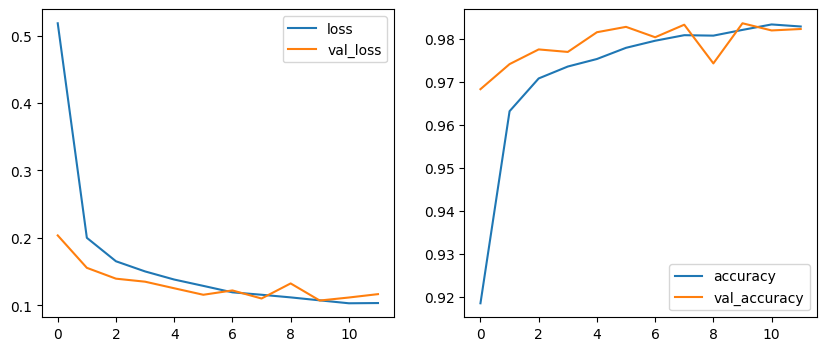

In [ ]:
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df1 = pd.DataFrame(L1_regularizer_model_history.history)
history_df1[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df1[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

Step 7: Evaluate the model

In [ ]:
test_images_scaled = test_images_gr / 255
L1_regularizer_model.evaluate(test_images_scaled,test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0991 - accuracy: 0.9852


[0.09910591691732407, 0.9851999878883362]

Step 8: Test the model (Make predictions)

In [ ]:
predictions1 = L1_regularizer_model.predict(test_images_scaled)
predictions1[:5]

313/313 [==============================] - 1s 2ms/step


array([[1.0392348e-09, 5.2866528e-07, 1.1427895e-06, 8.1152739e-06,
        1.1616845e-07, 5.7870415e-09, 8.0435146e-12, 9.9993038e-01,
        7.0716069e-08, 5.9645678e-05],
       [1.0394834e-07, 8.9495529e-07, 9.9999869e-01, 4.2565624e-08,
        9.3802487e-11, 1.6653848e-11, 3.7397839e-07, 2.9559899e-09,
        1.3076340e-08, 1.7470603e-11],
       [1.8924536e-06, 9.9916375e-01, 1.7633998e-05, 3.2930179e-06,
        1.9507305e-04, 7.0565598e-05, 5.8611342e-05, 1.5040275e-04,
        3.0767810e-04, 3.1074946e-05],
       [9.9991584e-01, 2.7436894e-08, 7.7346755e-07, 2.9116390e-07,
        1.2705949e-06, 1.7872525e-06, 4.7273592e-05, 4.0760797e-06,
        4.6839767e-07, 2.8207282e-05],
       [1.3735944e-07, 1.3853124e-08, 9.0653253e-07, 2.6151781e-08,
        9.9979991e-01, 7.8705909e-08, 1.6531415e-07, 2.0503320e-07,
        8.4930991e-07, 1.9765946e-04]], dtype=float32)

In [ ]:
prediction_labels = np.argmax(predictions1, axis=1)
prediction_labels[:5]

array([7, 2, 1, 0, 4])

## Visualize the model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

        ZERO       0.99      1.00      0.99       980
         ONE       0.99      0.99      0.99      1135
         TWO       0.99      0.98      0.98      1032
       THREE       0.98      0.99      0.98      1010
        FOUR       0.99      0.99      0.99       982
        FIVE       0.98      0.98      0.98       892
         SIX       0.99      0.99      0.99       958
       SEVEN       0.99      0.97      0.98      1028
       EIGHT       0.98      0.98      0.98       974
        NINE       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



,ZERO,ONE,TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,NINE
ZERO,976,0,0,0,0,0,1,1,2,0
ONE,0,1125,0,2,0,0,4,0,4,0
TWO,2,2,1012,3,0,0,0,7,6,0
THREE,0,0,3,999,0,3,0,1,3,1
FOUR,0,0,1,0,975,0,3,0,0,3
FIVE,2,0,0,7,0,876,2,0,1,4
SIX,3,2,0,0,1,6,945,0,1,0
SEVEN,0,1,7,3,2,0,0,1001,3,11
EIGHT,3,0,0,5,0,2,0,3,957,4
NINE,0,2,0,4,11,4,0,2,0,986


<Figure size 2000x3000 with 0 Axes>

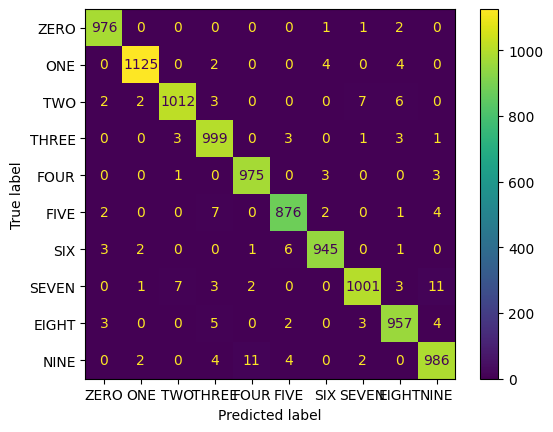

In [ ]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(test_labels, prediction_labels, display_labels=class_names)
plt.show()

In [ ]:
prediction_labels[:20]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

In [ ]:
test_labels[:20]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
      dtype=uint64)

#### Using the L2 Regularizer

In [ ]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
L2_regularizer_model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
L2_regularizer_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer='L2',
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
L2_regularizer_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
L2_regularizer_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer='L2',
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
L2_regularizer_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
L2_regularizer_model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
L2_regularizer_model.add(tf.keras.layers.Dense(256, activation='relu'))
L2_regularizer_model.add(tf.keras.layers.Dropout(rate=0.3))
L2_regularizer_model.add(tf.keras.layers.Dense(256, activation='relu'))
L2_regularizer_model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
L2_regularizer_model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
L2_regularizer_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# view model layers
L2_regularizer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [ ]:
train_images_scaled = train_images_gr / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
                                               restore_best_weights=True,
                                               verbose=1)

L2_regularizer_model_history = L2_regularizer_model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback],
                    validation_split=0.2, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1500/1500 [==============================] - 9s 5ms/step - loss: 0.3065 - accuracy: 0.9283 - val_loss: 0.1210 - val_accuracy: 0.9775
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1273 - accuracy: 0.9722 - val_loss: 0.0869 - val_accuracy: 0.9842
Epoch 3/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1003 - accuracy: 0.9789 - val_loss: 0.0778 - val_accuracy: 0.9848
Epoch 4/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0869 - accuracy: 0.9809 - val_loss: 0.0850 - val_accuracy: 0.9812
Epoch 5/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0758 - accuracy: 0.9834 - val_loss: 0.0632 - val_accuracy: 0.9879
Epoch 6/100
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0694 - accuracy: 0.9852 - val_loss: 0.0656 - val_accuracy: 0.9870
Epoch 7/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0641 - accuracy: 0.9862 - val_loss: 0.0617 - val_

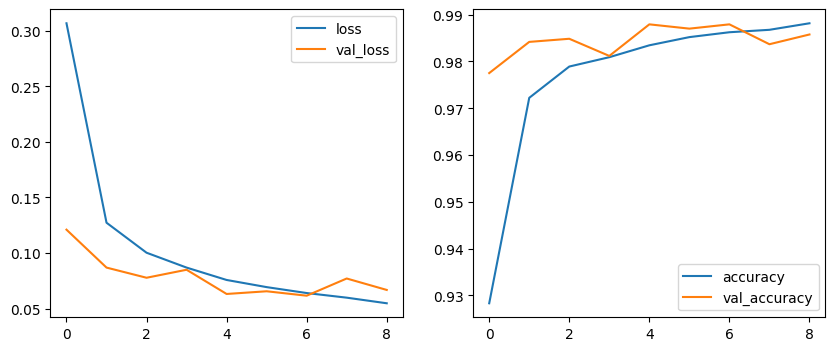

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df2 = pd.DataFrame(L2_regularizer_model_history.history)
history_df2[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df2[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
L2_regularizer_model.evaluate(test_images_scaled,test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0539 - accuracy: 0.9904


[0.053940270096063614, 0.9904000163078308]

313/313 [==============================] - 1s 2ms/step


<Figure size 2000x3000 with 0 Axes>

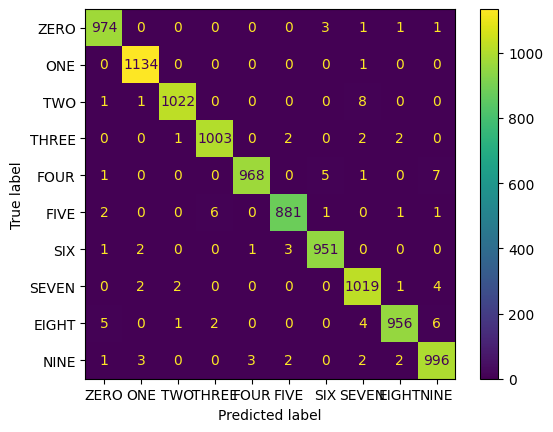

In [ ]:
pred2 = L2_regularizer_model.predict(test_images_scaled)
pred2_labels = np.argmax(pred2, axis=1)
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(test_labels, pred2_labels, display_labels=class_names)
plt.show()

## increasing the number of con2D blocks to 3 blocks

In [ ]:

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer='L2',
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer='L2',
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 3
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer='L2',
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 64)        

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
                                               restore_best_weights=True,
                                               verbose=1)

model_history = model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback],
                    validation_split=0.2, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1500/1500 [==============================] - 11s 6ms/step - loss: 0.5432 - accuracy: 0.8860 - val_loss: 0.2446 - val_accuracy: 0.9693
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2683 - accuracy: 0.9563 - val_loss: 0.2135 - val_accuracy: 0.9695
Epoch 3/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2301 - accuracy: 0.9625 - val_loss: 0.1950 - val_accuracy: 0.9709
Epoch 4/100
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2100 - accuracy: 0.9662 - val_loss: 0.2172 - val_accuracy: 0.9602
Epoch 5/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1963 - accuracy: 0.9681 - val_loss: 0.2119 - val_accuracy: 0.9614
Epoch 5: early stopping


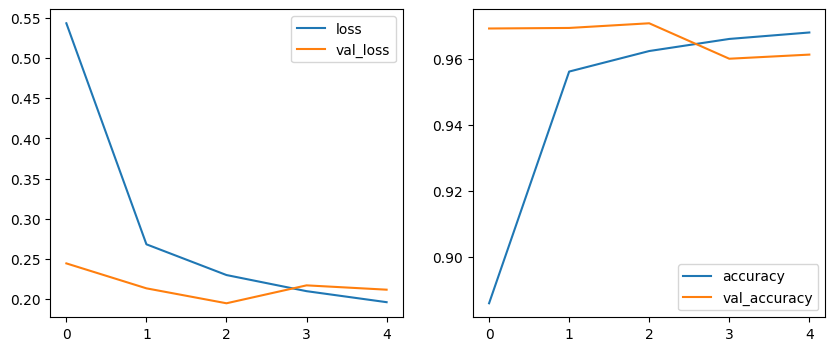

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df3 = pd.DataFrame(model_history.history)
history_df3[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df3[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
model.evaluate(test_images_scaled,test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.1938 - accuracy: 0.9706


[0.1937693953514099, 0.9706000089645386]

313/313 [==============================] - 1s 2ms/step


<Figure size 2000x3000 with 0 Axes>

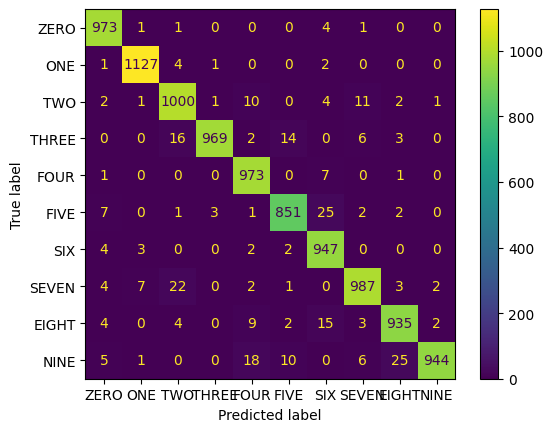

In [ ]:
pred3 = model.predict(test_images_scaled)
pred3_labels = np.argmax(pred3, axis=1)
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(test_labels, pred3_labels, display_labels=class_names)
plt.show()

## Varying the learning rate

### using lr=0.1

In [ ]:

# define sequential model
lr1_model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
lr1_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.L2(l=0.1),
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
lr1_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
lr1_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.L2(l=0.1),
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
lr1_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# add flatten layer
lr1_model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
lr1_model.add(tf.keras.layers.Dense(256, activation='relu'))
lr1_model.add(tf.keras.layers.Dropout(rate=0.3))
lr1_model.add(tf.keras.layers.Dense(256, activation='relu'))
lr1_model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
lr1_model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
lr1_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# view model layers
lr1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_9 (Dense)             (None, 256)              

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
                                               restore_best_weights=True,
                                               verbose=1)

lr1_model_history = lr1_model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback],
                    validation_split=0.2, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1500/1500 [==============================] - 10s 5ms/step - loss: 0.4463 - accuracy: 0.9132 - val_loss: 0.1986 - val_accuracy: 0.9609
Epoch 2/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1820 - accuracy: 0.9612 - val_loss: 0.1365 - val_accuracy: 0.9728
Epoch 3/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1423 - accuracy: 0.9691 - val_loss: 0.1209 - val_accuracy: 0.9744
Epoch 4/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1216 - accuracy: 0.9737 - val_loss: 0.1060 - val_accuracy: 0.9788
Epoch 5/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1115 - accuracy: 0.9761 - val_loss: 0.0985 - val_accuracy: 0.9795
Epoch 6/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1006 - accuracy: 0.9781 - val_loss: 0.0915 - val_accuracy: 0.9808
Epoch 7/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0959 - accuracy: 0.9789 - val_loss: 0.0879 - val_a

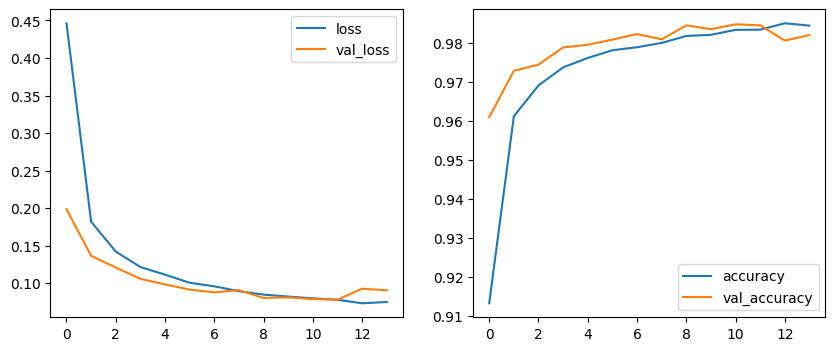

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df4 = pd.DataFrame(lr1_model_history.history)
history_df4[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df4[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
lr1_model.evaluate(test_images_scaled,test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0729 - accuracy: 0.9868


[0.07293989509344101, 0.9868000149726868]

313/313 [==============================] - 1s 2ms/step


<Figure size 2000x3000 with 0 Axes>

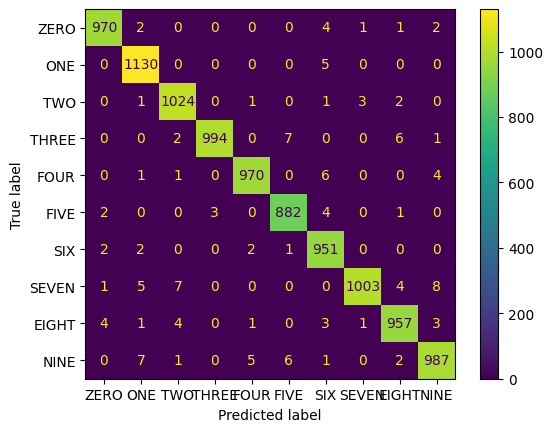

In [ ]:
pred4 = lr1_model.predict(test_images_scaled)
pred4_labels = np.argmax(pred4, axis=1)
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(test_labels, pred4_labels, display_labels=class_names)
plt.show()

### using lr=0.01

In [ ]:

# define sequential model
lr2_model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
lr2_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.L2(l=0.01),
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
lr2_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
lr2_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.L2(l=0.01),
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
lr2_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# add flatten layer
lr2_model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
lr2_model.add(tf.keras.layers.Dense(256, activation='relu'))
lr2_model.add(tf.keras.layers.Dropout(rate=0.3))
lr2_model.add(tf.keras.layers.Dense(256, activation='relu'))
lr2_model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
lr2_model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
lr2_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# view model layers
lr1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_9 (Dense)             (None, 256)              

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
                                               restore_best_weights=True,
                                               verbose=1)

lr2_model_history = lr2_model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback],
                    validation_split=0.2, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1500/1500 [==============================] - 10s 5ms/step - loss: 0.2962 - accuracy: 0.9312 - val_loss: 0.1050 - val_accuracy: 0.9818
Epoch 2/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1236 - accuracy: 0.9736 - val_loss: 0.0978 - val_accuracy: 0.9800
Epoch 3/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0995 - accuracy: 0.9791 - val_loss: 0.0702 - val_accuracy: 0.9872
Epoch 4/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0831 - accuracy: 0.9826 - val_loss: 0.0852 - val_accuracy: 0.9812
Epoch 5/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0752 - accuracy: 0.9844 - val_loss: 0.0689 - val_accuracy: 0.9872
Epoch 6/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0682 - accuracy: 0.9861 - val_loss: 0.0636 - val_accuracy: 0.9877
Epoch 7/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0644 - accuracy: 0.9867 - val_loss: 0.0721 - val_a

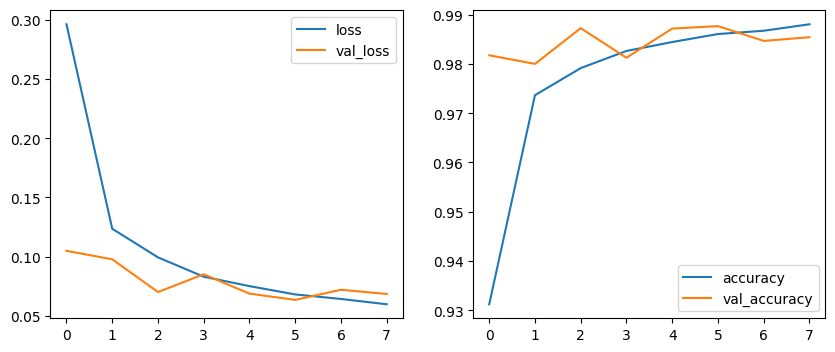

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df5 = pd.DataFrame(lr2_model_history.history)
history_df5[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df5[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
lr2_model.evaluate(test_images_scaled,test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0562 - accuracy: 0.9884


[0.056185174733400345, 0.9883999824523926]

313/313 [==============================] - 1s 2ms/step


<Figure size 2000x3000 with 0 Axes>

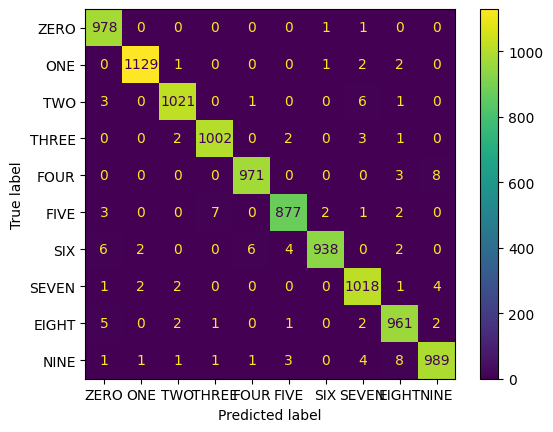

In [ ]:
pred5 = lr2_model.predict(test_images_scaled)
pred5_labels = np.argmax(pred5, axis=1)
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(test_labels, pred5_labels, display_labels=class_names)
plt.show()

### using lr=0.001

In [ ]:

# define sequential model
lr3_model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
lr3_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.L2(l=0.001),
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
lr3_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
lr3_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.L2(l=0.001),
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
lr3_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# add flatten layer
lr3_model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
lr3_model.add(tf.keras.layers.Dense(256, activation='relu'))
lr3_model.add(tf.keras.layers.Dropout(rate=0.3))
lr3_model.add(tf.keras.layers.Dense(256, activation='relu'))
lr3_model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
lr3_model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
lr3_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# view model layers
lr3_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 800)               0         
                                                                 
 dense_15 (Dense)            (None, 256)              

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,
                                               restore_best_weights=True,
                                               verbose=1)

lr3_model_history = lr3_model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback],
                    validation_split=0.2, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1500/1500 [==============================] - 10s 5ms/step - loss: 0.2318 - accuracy: 0.9348 - val_loss: 0.0805 - val_accuracy: 0.9824
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0902 - accuracy: 0.9789 - val_loss: 0.0707 - val_accuracy: 0.9850
Epoch 3/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0722 - accuracy: 0.9826 - val_loss: 0.0627 - val_accuracy: 0.9867
Epoch 4/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0579 - accuracy: 0.9875 - val_loss: 0.0562 - val_accuracy: 0.9892
Epoch 5/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0529 - accuracy: 0.9882 - val_loss: 0.0604 - val_accuracy: 0.9874
Epoch 6/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0470 - accuracy: 0.9898 - val_loss: 0.0552 - val_accuracy: 0.9892
Epoch 7/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0407 - accuracy: 0.9911 - val_loss: 0.0647 - val_a

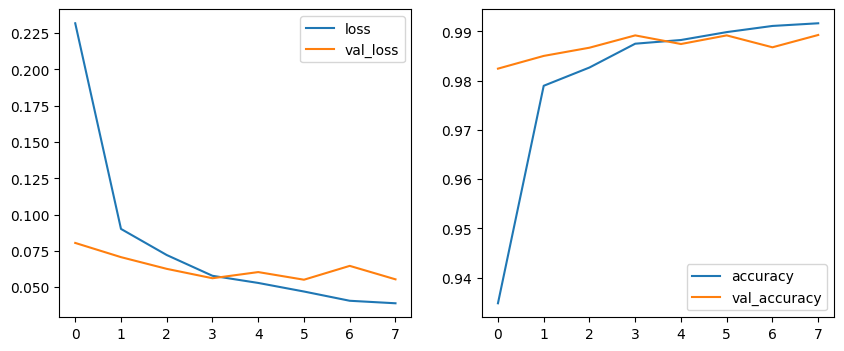

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df6 = pd.DataFrame(lr3_model_history.history)
history_df6[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df6[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
lr3_model.evaluate(test_images_scaled,test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0478 - accuracy: 0.9900


[0.04779478535056114, 0.9900000095367432]

In [ ]:
pred = lr3_model.predict(test_images_scaled)
pred_labels = np.argmax(predictions1, axis=1)


313/313 [==============================] - 1s 2ms/step


<Figure size 2000x3000 with 0 Axes>

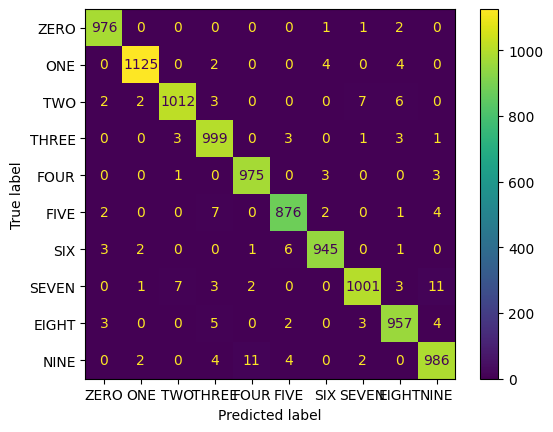

In [ ]:
plt.figure(dpi=200, figsize=(10,15))
ConfusionMatrixDisplay.from_predictions(test_labels, pred_labels, display_labels=class_names)
plt.show()

# Overall Conclusion

# From the above analysis, it was observed that the lower the learning rate, the better the performance also, the higher the number of convolutionary blocks, the lower the Model performance. After changing the number of blocks and checking varying learning rates, the Model did not overfit at any point.